In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/TSL/

/content/drive/My Drive/TSL


Numpy2parquet

In [ ]:
import os
import numpy as np
import pandas as pd

def extract_data(directory):
    all_data = []
    
    filenames = os.listdir(directory)

    for filename in filenames:
        if filename.endswith(".npy"):
            # Remove the ".npy" extension from the filename
            frame = os.path.splitext(filename)[0]
            
            file_path = os.path.join(directory, filename)
            data = np.load(file_path)
            
            num_face_rows = 468
            num_pose_rows = 33
            num_left_hand_rows = 21
            num_right_hand_rows = 21
            
            row_ids = []  
            types = []
            for i in range(num_face_rows):
                row_ids.append(f"{frame}-face-{i}")
                types.append("face")

            for i in range(num_left_hand_rows):
                row_ids.append(f"{frame}-left hand-{i}")
                types.append("left hand") 

            for i in range(num_pose_rows):
                row_ids.append(f"{frame}-pose-{i}")
                types.append("pose")
             
            for i in range(num_right_hand_rows):
                row_ids.append(f"{frame}-right hand-{i}")
                types.append("right hand")
                
            combined_data = data.reshape(-1, 3)
            
            df = pd.DataFrame(combined_data, columns=["x", "y", "z"])
            df["frame"] = frame
            df["row_id"] = row_ids
            df["type"] = types
            
            # Extracting the landmark index from the row_ids
            df["landmark_index"] = [str(row_id.split("-")[-1]) for row_id in row_ids]
            
            df.replace(0, np.nan, inplace=True)
            
            all_data.append(df)
            
    if not all_data:
        print(f"No .npy files found in directory: {directory}")
        return pd.DataFrame()  # Return an empty DataFrame
        
    all_data = pd.concat(all_data, ignore_index=True)
    
    # Reorder columns
    columns_order = ['frame', 'row_id', 'type', 'landmark_index', 'x', 'y', 'z']
    all_data = all_data[columns_order]
    
    return all_data

# Create a new directory to store the Parquet files
output_directory = 'allnewpreprocessing_parquet'
os.makedirs(output_directory, exist_ok=True)

# Input directory containing all the subdirectories
input_directory = 'allnewdata'

# Iterate through all subdirectories and process each one
for subdir in os.listdir(input_directory):
    subdirectory = os.path.join(input_directory, subdir)
    
    if os.path.isdir(subdirectory):
        output_subdirectory = os.path.join(output_directory, subdir)
        os.makedirs(output_subdirectory, exist_ok=True)
        
        # Iterate through all subdirectories within each subdirectory
        for subsubdir in os.listdir(subdirectory):
            subsubdirectory = os.path.join(subdirectory, subsubdir)
            
            if os.path.isdir(subsubdirectory):
                # Extract data and save to Parquet file
                features_df = extract_data(subsubdirectory)
                if not features_df.empty:
                    output_file_path = os.path.join(output_subdirectory, f"{subsubdir}.parquet")
                    features_df.to_parquet(output_file_path)
                    print(f"DataFrame saved to Parquet file: {output_file_path}")

Flip data

In [ ]:
import os
import pandas as pd

# Function to apply horizontal flipping to keypoints
def flip_keypoints(df):
    df['x'] = -df['x']  # Flip the x-coordinates
    return df

# Function to swap the type field for right and left hand
def swap_hand_types(df):
    df['type'] = df['type'].replace({'right hand': 'temp_hand', 'left hand': 'right hand', 'temp_hand': 'left hand'})
    return df

# Function to process a single Parquet file
def process_parquet_file(input_file, output_file):
    df = pd.read_parquet(input_file)
    df = flip_keypoints(df)
    df = swap_hand_types(df)
    df.to_parquet(output_file)
    print(f"Augmented DataFrame saved to Parquet file: {output_file}")

# Define input and output directories
input_dir = 'allnewpreprocessing_parquet'
output_dir = 'preprocessed_5_parquet'
start_folder = 30
# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Iterate through each folder and file in the input directory
for folder in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder)
    if os.path.isdir(folder_path):
        output_folder_path = os.path.join(output_dir, folder)
        os.makedirs(output_folder_path, exist_ok=True)
        
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.parquet'):
                input_file_path = os.path.join(folder_path, file_name)
                filename_int = file_name.replace(".parquet", "")
                output_file_path = os.path.join(output_folder_path, f"{int(filename_int) + start_folder}.parquet")
                
                # Process each Parquet file
                process_parquet_file(input_file_path, output_file_path)


Visualize

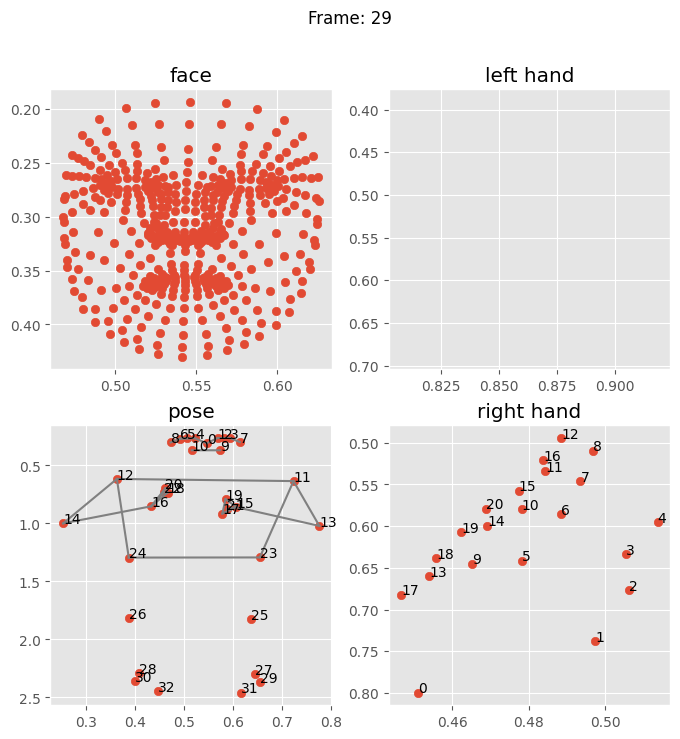

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Define the edges for the landmarks
edges = {
    "left_hand": [
        (0, 1), (1, 2), (2, 3), (3, 4), (0, 5), (0, 17), (5, 6), (6, 7),
        (7, 8), (5, 9), (9, 10), (10, 11), (11, 12), (9, 13), (13, 14),
        (14, 15), (15, 16), (13, 17), (17, 18), (18, 19), (19, 20)
    ],
    "right_hand": [
        (0, 1), (1, 2), (2, 3), (3, 4), (0, 5), (0, 17), (5, 6), (6, 7),
        (7, 8), (5, 9), (9, 10), (10, 11), (11, 12), (9, 13), (13, 14),
        (14, 15), (15, 16), (13, 17), (17, 18), (18, 19), (19, 20)
    ],
    "pose": [
        (8, 6), (6, 5), (6, 4), (4, 0), (0, 1), (1, 2), (2, 3), (3, 7),
        (10, 9), (11, 12), (11, 13), (11, 23), (13, 15), (15, 21), (15, 17),
        (15, 19), (17, 19), (12, 14), (12, 24), (14, 16), (16, 22), (16, 20),
        (16, 18), (18, 20), (23, 24)
    ],
}

# Read the data from the Parquet file
df = pd.read_parquet('21.parquet')

# Function to draw the landmarks for each frame
def draw_frame(frame, lms_all, axes, edges):
    lms = [group for _, group in lms_all[frame].groupby('type')]
    for lm, ax in zip(lms, axes):
        ax.cla()
        lm_type = lm.iloc[0]['type']
        ax.scatter(lm['x'], lm['y'])
        if lm_type != "face":
            for i, row in lm.iterrows():
                ax.text(row['x'], row['y'], row['landmark_index'])
        if lm_type in edges:
            for edge in edges[lm_type]:
                i, j = edge
                x1, x2 = lm.iloc[i]['x'], lm.iloc[j]['x']
                y1, y2 = lm.iloc[i]['y'], lm.iloc[j]['y']
                if pd.notnull(x1) and pd.notnull(x2) and pd.notnull(y1) and pd.notnull(y2):
                    ax.plot([x1, x2], [y1, y2], color='gray')
        ax.set_title(lm_type)
        ax.invert_yaxis()
    plt.suptitle(f'Frame: {frame}')

# Initialize the plot
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()

# Group the data by frames
lms_all = [frame for _, frame in df.groupby('frame')]

# Create the animation
ani = animation.FuncAnimation(fig, draw_frame, fargs=(lms_all, axes, edges), frames=len(lms_all), interval=100)

# Save the animation
ani.save('animation.mp4', writer='ffmpeg')

plt.show()
